In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets

In [17]:
customers = pd.read_csv("Customers.csv")
products = pd.read_csv("Products.csv")
transactions = pd.read_csv("Transactions.csv")

# Quick overview of data

In [18]:
print(customers.head(), products.head(), transactions.head())

  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15   ProductID              ProductName     Category   Price
0      P001     ActiveWear Biography        Books  169.30
1      P002    ActiveWear Smartwatch  Electronics  346.30
2      P003  ComfortLiving Biography        Books   44.12
3      P004            BookWorld Rug   Home Decor   95.69
4      P005          TechPro T-Shirt     Clothing  429.31   TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067   2024-04-25 7:38:55         1   
3       

# Check missing values

In [19]:
print(customers.isnull().sum(), products.isnull().sum(), transactions.isnull().sum())

CustomerID      0
CustomerName    0
Region          0
SignupDate      0
dtype: int64 ProductID      0
ProductName    0
Category       0
Price          0
dtype: int64 TransactionID      0
CustomerID         0
ProductID          0
TransactionDate    0
Quantity           0
TotalValue         0
Price              0
dtype: int64


# Convert date columns to datetime format


In [20]:
customers["SignupDate"] = pd.to_datetime(customers["SignupDate"])
transactions["TransactionDate"] = pd.to_datetime(transactions["TransactionDate"])

# Merge datasets


In [21]:
merged_df = transactions.merge(customers, on="CustomerID").merge(products, on="ProductID")

In [22]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Prepare customer-product matrix


In [23]:
customer_product_matrix = merged_df.pivot_table(index="CustomerID", columns="ProductID", values="Quantity", fill_value=0)

# Compare Similarity

In [24]:
similarity_matrix = cosine_similarity(customer_product_matrix)
similarity_df = pd.DataFrame(similarity_matrix, index=customer_product_matrix.index, columns=customer_product_matrix.index)

In [25]:
# Function to get top 3 similar customers
def get_top_3_similar(customers_list):
    lookalike_data = {}
    for cust_id in customers_list:
        similar_customers = similarity_df.loc[cust_id].sort_values(ascending=False)[1:4]
        lookalike_data[cust_id] = list(zip(similar_customers.index, similar_customers.values))
    return lookalike_data

# Get lookalike recommendations for customers C0001 - C0020

In [26]:
lookalikes = get_top_3_similar(customers["CustomerID"][:20])

# Save to CSV


In [29]:
lookalike_df = pd.DataFrame.from_dict(lookalikes, orient="index")
lookalike_df.to_csv("Vruddhi_Shah_Lookalike.csv")

DB Index: 0.7017151020215118


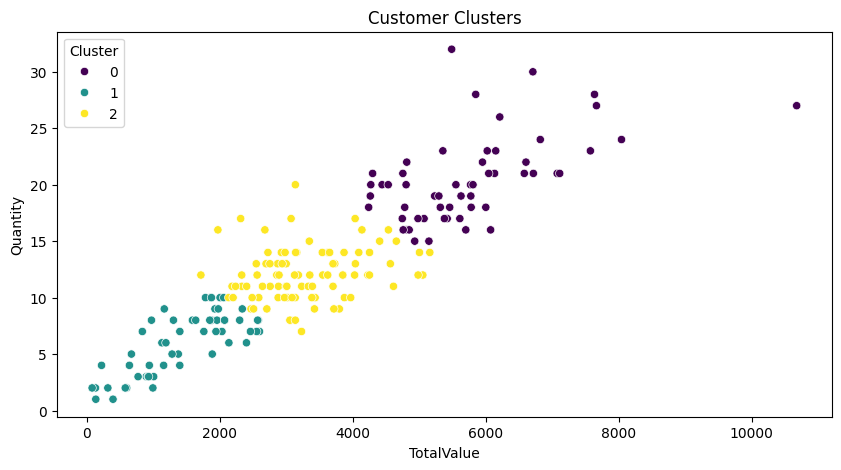

In [30]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
import seaborn as sns

# Prepare data for clustering
features = merged_df.groupby("CustomerID").agg({"TotalValue": "sum", "Quantity": "sum"}).reset_index()
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features[["TotalValue", "Quantity"]])

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
features["Cluster"] = kmeans.fit_predict(scaled_features)

# Calculate DB Index
db_index = davies_bouldin_score(scaled_features, features["Cluster"])
print("DB Index:", db_index)

# Visualize clusters
plt.figure(figsize=(10, 5))
sns.scatterplot(data=features, x="TotalValue", y="Quantity", hue="Cluster", palette="viridis")
plt.title("Customer Clusters")
plt.show()
